In [284]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error,r2_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold,train_test_split,RandomizedSearchCV
from sklearn.linear_model import LinearRegression


In [58]:
os.chdir("D:\DataScience_salary")

In [59]:
ds_df=pd.read_csv("glassdoor_jobs.txt")

In [60]:
ds_df.drop('Unnamed: 0',axis=1,inplace=True)

In [62]:
ds_df.tail()

,Job Title,Salary Estimate,Job Description,Rating,Company Name,Location,Headquarters,Size,Founded,Type of ownership,Industry,Sector,Revenue,Competitors
951,Senior Data Engineer,$72K-$133K (Glassdoor est.),THE CHALLENGE\nEventbrite has a world-class da...,4.4,Eventbrite\n4.4,"Nashville, TN","San Francisco, CA",1001 to 5000 employees,2006,Company - Public,Internet,Information Technology,$100 to $500 million (USD),"See Tickets, TicketWeb, Vendini"
952,"Project Scientist - Auton Lab, Robotics Institute",$56K-$91K (Glassdoor est.),The Auton Lab at Carnegie Mellon University is...,2.6,Software Engineering Institute\n2.6,"Pittsburgh, PA","Pittsburgh, PA",501 to 1000 employees,1984,College / University,Colleges & Universities,Education,Unknown / Non-Applicable,-1
953,Data Science Manager,$95K-$160K (Glassdoor est.),Data Science ManagerResponsibilities:\n\nOvers...,3.2,"Numeric, LLC\n3.2","Allentown, PA","Chadds Ford, PA",1 to 50 employees,-1,Company - Private,Staffing & Outsourcing,Business Services,$5 to $10 million (USD),-1
954,Data Engineer,-1,Loading...\n\nTitle: Data Engineer\n\nLocation...,4.8,IGNW\n4.8,"Austin, TX","Portland, OR",201 to 500 employees,2015,Company - Private,IT Services,Information Technology,$25 to $50 million (USD),Slalom
955,Research Scientist – Security and Privacy,$61K-$126K (Glassdoor est.),Returning Candidate? Log back in to the Career...,3.6,Riverside Research Institute\n3.6,"Beavercreek, OH","Arlington, VA",501 to 1000 employees,1967,Nonprofit Organization,Federal Agencies,Government,$50 to $100 million (USD),-1


In [63]:
ds_df.columns

Index(['Job Title', 'Salary Estimate', 'Job Description', 'Rating',
       'Company Name', 'Location', 'Headquarters', 'Size', 'Founded',
       'Type of ownership', 'Industry', 'Sector', 'Revenue', 'Competitors'],
      dtype='object')

# Data Cleaning

In [64]:
def title_extraction(title):
    title=title.strip()
    if "director" in title.lower():
        return "director"
    elif ('machine learning' in title.lower())|bool(re.search("ML",title))==True:
        return 'machine learning'
    elif ("data scientist" in title.lower())|bool(re.search("Data Science",title))==True:
        return "data scientist"
    elif "data engineer" in title.lower():
        return "data engineer"
    elif "manager" in title.lower():
        return "manager"
    elif ("analyst" in title.lower())|(bool(re.search("Analysis ",title))==True) | (bool(re.search("Analytics",title))==True):        
        return "analyst"
    else:
        return "other"
def level(title):
    if 'sr' in title.lower() or 'senior' in title.lower() or 'sr' in title.lower() or 'lead' in title.lower() or 'principal' in title.lower():
            return 'senior'
    elif 'jr' in title.lower() or 'jr.' in title.lower():
        return 'jr'
    else:
        return 'na'

In [65]:
ds_df["Job_title_dum"]=ds_df["Job Title"].apply(title_extraction)
ds_df["Job_level"]=ds_df["Job Title"].apply(level)

In [66]:
def job_state(location):
    x=location.split(",")[-1]
    if x=="Virginia":
        x="VA"
    elif x=="New Jersey":
        x="NJ"
    elif x=="Oregon":
        x="OR"
    elif x=="Maryland":
        x="MD"
    elif x=="Michigan":
        x="MI"
    else:
        x=x
    return x.strip()
ds_df["Job_state"]=ds_df["Location"].apply(job_state)

In [67]:
ds_df["no_comp"]=ds_df["Competitors"].apply(lambda x: len(x.split(",")) if x!="-1" else 0)

In [68]:
ds_df['hourly'] = ds_df['Salary Estimate'].apply(lambda x: 1 if 'per hour' in x.lower() else 0)
ds_df['employer_provided'] = ds_df['Salary Estimate'].apply(lambda x: 1 if 'employer provided salary:' in x.lower() else 0)

In [69]:
ds_df = ds_df[ds_df['Salary Estimate'] != '-1']

salary = ds_df['Salary Estimate'].apply(lambda x: x.split('(')[0])

minus_Kd = salary.apply(lambda x: x.replace('K','').replace('$',''))

min_hr = minus_Kd.apply(lambda x: x.lower().replace('per hour','').replace('employer provided salary:',''))



In [70]:
ds_df['min_salary'] = min_hr.apply(lambda x: int(x.split('-')[0]))
ds_df['max_salary'] = min_hr.apply(lambda x: int(x.split('-')[1]))
ds_df['avg_salary'] = (ds_df.min_salary+ds_df.max_salary)/2


In [71]:
ds_df.columns

Index(['Job Title', 'Salary Estimate', 'Job Description', 'Rating',
       'Company Name', 'Location', 'Headquarters', 'Size', 'Founded',
       'Type of ownership', 'Industry', 'Sector', 'Revenue', 'Competitors',
       'Job_title_dum', 'Job_level', 'Job_state', 'no_comp', 'hourly',
       'employer_provided', 'min_salary', 'max_salary', 'avg_salary'],
      dtype='object')

In [72]:
ds_df["Company Name"]

0                          Tecolote Research\n3.8
1      University of Maryland Medical System\n3.4
2                                    KnowBe4\n4.8
3                                       PNNL\n3.8
4                         Affinity Solutions\n2.9
                          ...                    
950                                      GSK\n3.9
951                               Eventbrite\n4.4
952           Software Engineering Institute\n2.6
953                             Numeric, LLC\n3.2
955             Riverside Research Institute\n3.6
Name: Company Name, Length: 742, dtype: object

In [73]:
ds_df["Company Name"]=ds_df["Company Name"].apply(lambda x:x.split("\n")[0])

In [74]:
ds_df['min_salary'] = ds_df.apply(lambda x: x.min_salary*2 if x.hourly ==1 else x.min_salary, axis =1)
ds_df['max_salary'] = ds_df.apply(lambda x: x.max_salary*2 if x.hourly ==1 else x.max_salary, axis =1)

In [75]:
ds_df["Age"]=ds_df.Founded.apply(lambda x: x if x <1 else 2020 - x)

In [76]:
ds_df.describe()

,Rating,Founded,no_comp,hourly,employer_provided,min_salary,max_salary,avg_salary,Age
count,742.000000,742.000000,742.000000,742.000000,742.000000,742.000000,742.000000,742.000000,742.000000
mean,3.618868,1837.154987,1.053908,0.032345,0.022911,74.719677,128.149596,100.626011,46.591644
std,0.801210,497.183763,1.384239,0.177034,0.149721,30.980593,45.220324,38.855948,53.778815
min,-1.000000,-1.000000,0.000000,0.000000,0.000000,15.000000,16.000000,13.500000,-1.000000
25%,3.300000,1939.000000,0.000000,0.000000,0.000000,52.000000,96.000000,73.500000,11.000000
50%,3.700000,1988.000000,0.000000,0.000000,0.000000,69.500000,124.000000,97.500000,24.000000
75%,4.000000,2007.000000,3.000000,0.000000,0.000000,91.000000,155.000000,122.500000,59.000000
max,5.000000,2019.000000,4.000000,1.000000,1.000000,202.000000,306.000000,254.000000,276.000000


In [77]:
ds_df["same_state"]=ds_df.apply(lambda x:1 if x["Job_state"]==x["Headquarters"].split(",")[-1].strip() else 0,axis=1)

# Data Visualization

In [78]:
ds_df.columns

Index(['Job Title', 'Salary Estimate', 'Job Description', 'Rating',
       'Company Name', 'Location', 'Headquarters', 'Size', 'Founded',
       'Type of ownership', 'Industry', 'Sector', 'Revenue', 'Competitors',
       'Job_title_dum', 'Job_level', 'Job_state', 'no_comp', 'hourly',
       'employer_provided', 'min_salary', 'max_salary', 'avg_salary', 'Age',
       'same_state'],
      dtype='object')

C:\Users\user\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


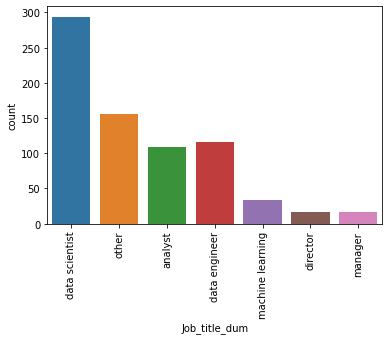

In [79]:
chart=sns.countplot(ds_df["Job_title_dum"])
chart.set_xticklabels(chart.get_xticklabels(), rotation=90)
plt.show()

C:\Users\user\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Rating', ylabel='Density'>

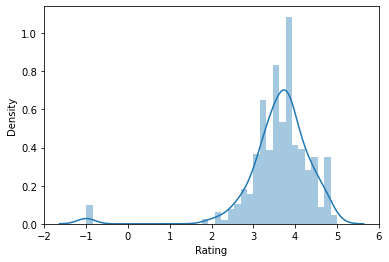

In [80]:
sns.distplot(ds_df["Rating"])

C:\Users\user\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='avg_salary', ylabel='Density'>

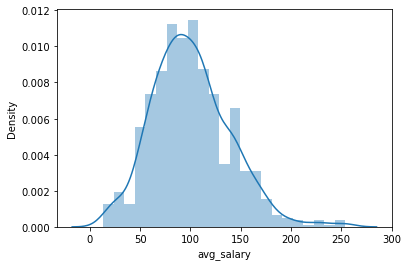

In [81]:
sns.distplot(ds_df["avg_salary"])

C:\Users\user\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Rating', ylabel='avg_salary'>

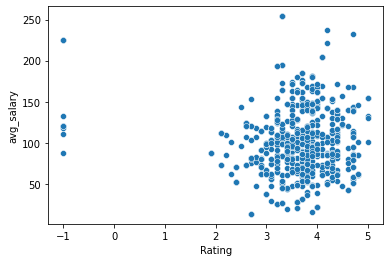

In [82]:
sns.scatterplot(ds_df["Rating"],ds_df["avg_salary"])

graph for Location: total = 20


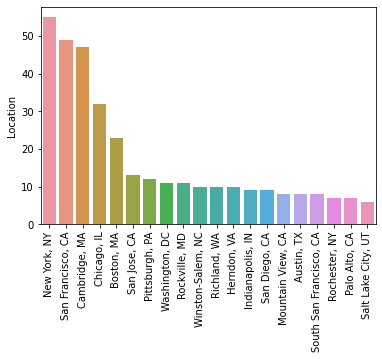

graph for Headquarters: total = 20


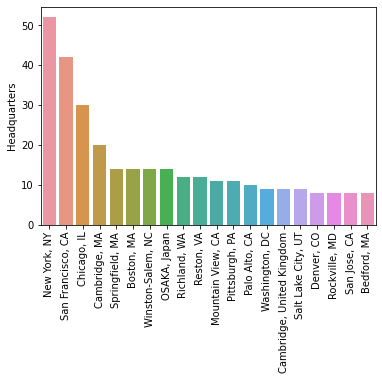

graph for Company Name: total = 20


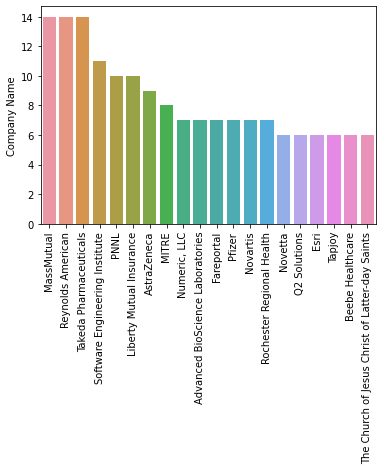

In [83]:
for i in ds_df[['Location','Headquarters','Company Name']].columns:
    cat_num = ds_df[i].value_counts()[:20]
    print("graph for %s: total = %d" % (i, len(cat_num)))
    chart = sns.barplot(x=cat_num.index, y=cat_num)
    chart.set_xticklabels(chart.get_xticklabels(), rotation=90)
    plt.show()

In [84]:
#Average salary of each job
pd.pivot_table(ds_df,index=["Job_title_dum"],values=["avg_salary"])

,avg_salary
Job_title_dum,
analyst,66.500000
data engineer,104.133621
data scientist,116.829932
director,166.117647
machine learning,111.852941
manager,73.218750
other,84.551282


In [85]:
# Average salary based on the seniority
pd.pivot_table(ds_df,index=["Job_title_dum","Job_level"],values=["avg_salary"])

avg_salary
Job_title_dum    Job_level            
analyst          jr          56.500000
                 na          62.425926
                 senior      79.092593
data engineer    na          94.506329
                 senior     124.689189
data scientist   jr         106.500000
                 na         106.959184
                 senior     136.881443
director         na         166.117647
machine learning na         105.291667
                 senior     127.600000
manager          na          73.218750
other            na          72.415888
                 senior     111.051020

In [86]:
# State wise salary for different positions
pd.pivot_table(ds_df,index=["Job_state","Job_title_dum"],values=["avg_salary"]).sort_values('Job_state', ascending = False)

avg_salary
Job_state Job_title_dum             
WI        other            54.000000
          data scientist  113.500000
          analyst          58.833333
WA        data scientist   99.764706
          analyst          65.250000
...                              ...
AZ        data scientist  106.166667
AL        data scientist   68.000000
          data engineer    65.000000
          other            43.750000
          analyst          60.750000

[116 rows x 1 columns]

In [87]:
# Salary of a Datascientist across all different states
pd.pivot_table(ds_df.loc[ds_df["Job_title_dum"]=="data scientist"],index=["Job_state","Job_title_dum"],values="avg_salary").sort_values(by="avg_salary",ascending=False)

,,avg_salary
Job_state,Job_title_dum,
DC,data scientist,149.000000
CA,data scientist,141.047297
UT,data scientist,140.500000
MO,data scientist,127.666667
NY,data scientist,117.945946
IL,data scientist,117.233333
NC,data scientist,117.000000
PA,data scientist,115.800000
WI,data scientist,113.500000


<AxesSubplot:>

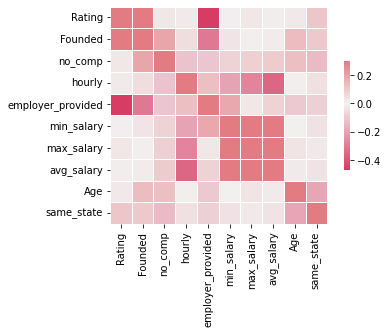

In [88]:
cmap = sns.diverging_palette(2,10, as_cmap=True)
sns.heatmap(ds_df.corr(),vmax=.3, center=0, cmap=cmap,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [89]:
ds_df.corr()

,Rating,Founded,no_comp,hourly,employer_provided,min_salary,max_salary,avg_salary,Age,same_state
Rating,1.000000,0.332927,0.027190,-0.019531,-0.468234,-0.009573,0.027344,0.013492,0.021655,0.110063
Founded,0.332927,1.000000,0.191265,0.049313,-0.312761,-0.033999,0.006776,-0.015149,0.134682,0.104474
no_comp,0.027190,0.191265,1.000000,-0.117265,-0.116665,0.076004,0.086195,0.093813,0.126687,-0.142833
hourly,-0.019531,0.049313,-0.117265,1.000000,0.124748,-0.203556,-0.276730,-0.356082,0.007626,0.043075
employer_provided,-0.468234,-0.312761,-0.116665,0.124748,1.000000,0.187591,0.028794,0.076287,-0.109288,-0.088833
min_salary,-0.009573,-0.033999,0.076004,-0.203556,0.187591,1.000000,0.940136,0.967765,0.003110,-0.039552
max_salary,0.027344,0.006776,0.086195,-0.276730,0.028794,0.940136,1.000000,0.986862,0.034395,-0.024442
avg_salary,0.013492,-0.015149,0.093813,-0.356082,0.076287,0.967765,0.986862,1.000000,0.019655,-0.036984
Age,0.021655,0.134682,0.126687,0.007626,-0.109288,0.003110,0.034395,0.019655,1.000000,-0.193164
same_state,0.110063,0.104474,-0.142833,0.043075,-0.088833,-0.039552,-0.024442,-0.036984,-0.193164,1.000000


In [90]:
ds_df['python_yn'] = ds_df['Job Description'].apply(lambda x: 1 if 'python' in x.lower() else 0)
 

In [91]:
ds_df["sql"]=ds_df['Job Description'].apply(lambda x: 1 if 'sql' in x.lower() else 0)


In [92]:

#excel
ds_df['excel'] = ds_df['Job Description'].apply(lambda x: 1 if 'excel' in x.lower() else 0)
ds_df.excel.value_counts()


1    388
0    354
Name: excel, dtype: int64

In [93]:
#aws 
ds_df['aws'] = ds_df['Job Description'].apply(lambda x: 1 if 'aws' in x.lower() else 0)
ds_df.aws.value_counts()


0    566
1    176
Name: aws, dtype: int64

In [94]:
#spark 
ds_df['spark'] = ds_df['Job Description'].apply(lambda x: 1 if 'spark' in x.lower() else 0)
ds_df.spark.value_counts()


0    575
1    167
Name: spark, dtype: int64

In [95]:
#r studio 
ds_df['R_yn'] = ds_df['Job Description'].apply(lambda x: 1 if 'r studio' in x.lower() or 'r-studio' in x.lower() else 0)
ds_df.R_yn.value_counts()


0    740
1      2
Name: R_yn, dtype: int64

# Model Building

In [96]:
ds_df.columns

Index(['Job Title', 'Salary Estimate', 'Job Description', 'Rating',
       'Company Name', 'Location', 'Headquarters', 'Size', 'Founded',
       'Type of ownership', 'Industry', 'Sector', 'Revenue', 'Competitors',
       'Job_title_dum', 'Job_level', 'Job_state', 'no_comp', 'hourly',
       'employer_provided', 'min_salary', 'max_salary', 'avg_salary', 'Age',
       'same_state', 'python_yn', 'sql', 'excel', 'aws', 'spark', 'R_yn'],
      dtype='object')

In [268]:
features_model = ds_df[['avg_salary','Rating','Size','Type of ownership','Industry','Sector','Revenue','no_comp','hourly','employer_provided',
             'Job_state','same_state','Age','python_yn','spark','aws','excel','Job_title_dum','Job_level','sql']]


In [164]:
features_model.head()

,avg_salary,Rating,Size,Type of ownership,Industry,Sector,Revenue,no_comp,hourly,employer_provided,Job_state,same_state,Age,python_yn,spark,aws,excel,Job_title_dum,Job_level,sql
0,72.0,3.8,501 to 1000 employees,Company - Private,Aerospace & Defense,Aerospace & Defense,$50 to $100 million (USD),0,0,0,NM,0,47,1,0,0,1,data scientist,na,0
1,87.5,3.4,10000+ employees,Other Organization,Health Care Services & Hospitals,Health Care,$2 to $5 billion (USD),0,0,0,MD,1,36,1,0,0,0,data scientist,na,0
2,85.0,4.8,501 to 1000 employees,Company - Private,Security Services,Business Services,$100 to $500 million (USD),0,0,0,FL,1,10,1,1,0,1,data scientist,na,1
3,76.5,3.8,1001 to 5000 employees,Government,Energy,"Oil, Gas, Energy & Utilities",$500 million to $1 billion (USD),3,0,0,WA,1,55,1,0,0,0,data scientist,na,0
4,114.5,2.9,51 to 200 employees,Company - Private,Advertising & Marketing,Business Services,Unknown / Non-Applicable,3,0,0,NY,1,22,1,0,0,1,data scientist,na,1


## Feature_Selection 

In [241]:
def model(data,target,encoding = 'ohe', n_folds = 5):
    #index
    feature_index=data.index
    # target/dependent
    target_variable=data[target]
    #independent features
    features=data.drop(target,axis=1)
    
    # encoding
    
    if encoding=="ohe":
        features=pd.get_dummies(features)
        
    elif encoding=="le":
        lb_ed=LabelEncoder()
        features_col=features.select_dtypes("O")
        for num,col in enumerate(features_col):
            features[col]=lb_ed.fit_transform(features[col])
            
    # Catch error if label encoding scheme is not valid
    else:
        raise ValueError("Encoding must be either 'ohe' or 'le'")
    
    # feature column names
    feature_select=list(features.columns)
    feature_importance_df = pd.DataFrame()
    feature_array=np.array(features)
    target_array=np.array(target_variable)
    
    # Appended_scores
    train_score=[]
    test_score=[]
    
    # Capture_feature_importance
    feature_importance=np.zeros(len(features.columns))
    
    # out_of_fold
    out_of_fold=np.zeros(features.shape[0])
    
    # 5 splits k-fold 
    kfold=KFold(n_splits=n_folds,shuffle=True,random_state=49)
    for count,(train_index,test_index) in enumerate(kfold.split(features)):
        #train,test
        x_train,y_train=feature_array[train_index],target_array[train_index]
        x_test,y_test=feature_array[test_index],target_array[test_index]
        
        # Model Building
        gbc=RandomForestRegressor()
        # Model fit
        gbc.fit(x_train,y_train)
        
        # Feature Importance
        feature_importance+=gbc.feature_importances_/kfold.n_splits
        
        # Train_Test Prediction        
        train_predict=gbc.predict(x_train)
        test_predict=gbc.predict(x_test)
        
        # Out_fold
        out_of_fold[test_index]=gbc.predict(x_test)
        
        # Accuracy score
        train_accuracy=mean_absolute_error(y_train,train_predict)
        test_accuracy=mean_absolute_error(y_test,test_predict)
        
        # Append the accuracy Score
        train_score.append(train_accuracy)
        test_score.append(test_accuracy)
    
    valid_scores=mean_absolute_error(target_variable,out_of_fold)
    
    test_score.append(valid_scores)
    train_score.append(np.mean(train_score))
    folds=list(range(n_folds))
    folds.append("Overall")
    feat_imp_df=pd.DataFrame({"column_name":feature_select,"feature_importance":feature_importance})
    cors=pd.DataFrame({"folds":folds,"trn_score":train_score,"tst_score":test_score})
    return feat_imp_df


In [272]:
eval_features=model(features_model,"avg_salary")
eval_features.head()

,column_name,feature_importance
0,Rating,0.057690
1,no_comp,0.012497
2,hourly,0.106407
3,employer_provided,0.004051
4,same_state,0.008672


### Selected Features

In [273]:
select_feat=eval_features.loc[eval_features["feature_importance"]>0.01,"column_name"].to_numpy()
features_mod=pd.get_dummies(features_model)

In [274]:
train_features=features_mod[select_feat]
target=features_mod['avg_salary']

## Model_Tuning with hyper-parameteres 

In [275]:
X_train,X_test,y_train,y_test=train_test_split(train_features,target,test_size=0.1)

In [276]:
rf = RandomForestRegressor()
param_dist = {"n_estimators":[100,200,300,500,700,1000],
              "max_features": [5,10,20,25,30,35],
                'max_depth':[None,5,10,15,20,30,50,70],
                'min_samples_leaf':[1,2,5,10,15,20], 
                'min_samples_split':[2,5,10,15,20]
                  }
rfs=RandomizedSearchCV(rf,param_distributions=param_dist,n_iter=10,cv=5,scoring="neg_mean_absolute_error")
model_fit=rfs.fit(X_train,y_train)
model_fit.best_estimator_

RandomForestRegressor(max_depth=30, max_features=35, min_samples_split=5,
                      n_estimators=700)

## Model Build with best estimator

In [291]:
modified_model=RandomForestRegressor(max_depth=30, max_features=35, min_samples_split=5,
                      n_estimators=700)
fit_=rf.fit(X_train,y_train)
predicted_x=fit_.predict(X_train)

In [292]:
mean_absolute_error(y_train,predicted_x)

5.3782451740954365

In [290]:
test_pred=fit_.predict(X_test)
score=mean_absolute_error(y_test,test_pred)
score
mean_absolute_error(y_train,predicted_x)

5.418374612435707